In [1]:
from gerrychain import Graph

In [2]:
# Read New Mexico county graph from the json file "NM_county.json"
filepath = 'C:\\Users\\loryn\\OneDrive\\Documents\\Python Scripts\\Operations Research\\'
filename = 'NM_county.json'

# GerryChain has a build-in function for reading graphs of this type:
G = Graph.from_json( filepath + filename )

In [3]:
# Find the name, population, longitude, and latitude of each county

for node in G.nodes:
    name = G.nodes[node]['NAME20']                     # Name of county
    county_population = G.nodes[node]['P0010001']      # Populaton of county
    G.nodes[node]['TOTPOP'] = county_population
    G.nodes[node]['C_X'] = G.nodes[node]['INTPTLON20'] # LONGITUDE of county center
    G.nodes[node]['C_Y'] = G.nodes[node]['INTPTLAT20'] # LATITUDE of county center
    x_coordinate = G.nodes[node]['C_X']
    y_coordinate = G.nodes[node]['C_Y']

    # Output the information
    print("Node", node, "is", name, "County, which has population", county_population, "and is centered at (",x_coordinate,",",y_coordinate,")")

Node 0 is Curry County, which has population 48430 and is centered at ( -103.3460546 , +34.5729841 )
Node 1 is Roosevelt County, which has population 19191 and is centered at ( -103.4830039 , +34.0212068 )
Node 2 is San Juan County, which has population 121661 and is centered at ( -108.3245778 , +36.5116245 )
Node 3 is Lincoln County, which has population 20269 and is centered at ( -105.4498055 , +33.7408411 )
Node 4 is Guadalupe County, which has population 4452 and is centered at ( -104.7849677 , +34.8697822 )
Node 5 is Torrance County, which has population 15045 and is centered at ( -105.8905574 , +34.5549784 )
Node 6 is Luna County, which has population 25427 and is centered at ( -107.7471911 , +32.1845231 )
Node 7 is McKinley County, which has population 72902 and is centered at ( -108.2532938 , +35.5840616 )
Node 8 is Rio Arriba County, which has population 40363 and is centered at ( -106.6939829 , +36.5096687 )
Node 9 is Lea County, which has population 74455 and is centered at 

In [4]:
# Geodesic can be used to find the distance between x and y coordinates
# A test of this for counties Mora and De Baca are shown below

from geopy.distance import geodesic

Mora = ( G.nodes[31]['C_Y'], G.nodes[31]['C_X'] )
De_Baca = ( G.nodes[16]['C_Y'], G.nodes[16]['C_X'] )

print( "Mora -> De Baca County:", geodesic(Mora, De_Baca).miles )

Mora -> De Baca County: 116.22165034291885


In [5]:
# create distance dictionary for the distance between any counties i and j

dist = dict()
for i in G.nodes:
    for j in G.nodes:
        loc_i = ( G.nodes[i]['C_Y'],  G.nodes[i]['C_X'] )
        loc_j = ( G.nodes[j]['C_Y'],  G.nodes[j]['C_X'] )
        dist[i,j] = geodesic(loc_i,loc_j).miles

In [6]:
# Let's impose a 1% population deviation (+/- 0.5%)
deviation = 0.01

import math

k = 3          # number of districts
total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)  # Population of New Mexico

L = math.ceil((1-deviation/2)*total_population/k) # Lower Bound of District Population
U = math.floor((1+deviation/2)*total_population/k) # Upper Bound of District Population

print("Using L =",L,"and U =",U,"and k =",k)

Using L = 702312 and U = 709369 and k = 3


In [7]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create x[i,j] variable which equals one when county i is assigned to (district centered at) county j
x = m.addVars(G.nodes, G.nodes, vtype=GRB.BINARY) 

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-17


In [8]:
# objective is to minimize the moment of inertia: d^2 * p * x
m.setObjective( gp.quicksum( dist[i,j]*dist[i,j]*G.nodes[i]['TOTPOP']*x[i,j] for i in G.nodes for j in G.nodes), GRB.MINIMIZE )

In [9]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in G.nodes) == 1 for i in G.nodes)

# add constraint saying there should be k district centers
m.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )

# add constraints that say: if j roots a district, then its population is between L and U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L * x[j,j] for j in G.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U * x[j,j] for j in G.nodes )

# add coupling constraints saying that if i is assigned to j, then j is a center.
m.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )

m.update()

In [10]:
# Add contiguity constraints

import networkx as nx
DG = nx.DiGraph(G)

# Add variable f[j,u,v] which equals the amount of flow (originally from j) that is sent across arc (u,v)
f = m.addVars( DG.nodes, DG.edges, vtype=GRB.CONTINUOUS)
M = DG.number_of_nodes()-1

# Add constraint saying that node j cannot receive flow of its own type
m.addConstrs( gp.quicksum( f[j,u,j] for u in DG.neighbors(j) ) == 0 for j in DG.nodes )

# Add constraints saying that node i can receive flow of type j only if i is assigned to j
m.addConstrs( gp.quicksum( f[j,u,i] for u in DG.neighbors(i)) <= M * x[i,j] for i in DG.nodes for j in DG.nodes if i != j )

# If i is assigned to j, then i should consume one unit of j flow. 
# Otherwise, i should consume no units of j flow.
m.addConstrs( gp.quicksum( f[j,u,i] - f[j,i,u] for u in DG.neighbors(i)) == x[i,j] for i in DG.nodes for j in DG.nodes if i != j )

m.update()


In [11]:
m.Params.MIPgap = 0.0
m.optimize()

Set parameter MIPGap to value 0
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3334 rows, 6237 columns and 22656 nonzeros
Model fingerprint: 0xef500b55
Variable types: 5148 continuous, 1089 integer (1089 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+05]
  Objective range  [2e+06, 4e+10]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 203 rows and 581 columns
Presolve time: 0.14s
Presolved: 3131 rows, 5656 columns, 21108 nonzeros
Variable types: 4603 continuous, 1053 integer (1053 binary)

Root relaxation: objective 1.217797e+10, 627 iterations, 0.03 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bou

In [12]:
print("The moment of inertia objective is",m.objval)

# retrieve the districts and their populations
centers = [j for j in G.nodes if x[j,j].x > 0.5 ]
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in centers]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])

# What is the population deviation for this model?
population_deviation = max(district_populations) - min(district_populations)
print("\nThe population deviation for this model is", population_deviation, "people.")

The moment of inertia objective is 12654737015.702263
District 0 has population 707195 and contains counties ['Bernalillo', 'Catron', 'Cibola']
District 1 has population 705274 and contains counties ['Curry', 'Roosevelt', 'Lincoln', 'Guadalupe', 'Luna', 'Lea', 'Chaves', 'Quay', 'Sierra', 'De Baca', 'Otero', 'San Miguel', 'Grant', 'Doña Ana', 'Hidalgo', 'Socorro', 'Eddy']
District 2 has population 705053 and contains counties ['San Juan', 'Torrance', 'McKinley', 'Rio Arriba', 'Santa Fe', 'Valencia', 'Union', 'Taos', 'Colfax', 'Sandoval', 'Harding', 'Los Alamos', 'Mora']

The population deviation for this model is 2142 people.


In [13]:
# Create a map for solution
import geopandas as gpd

In [14]:
# Read New Mexico county shapefile from "NM_county.shp"

filename = 'NM_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

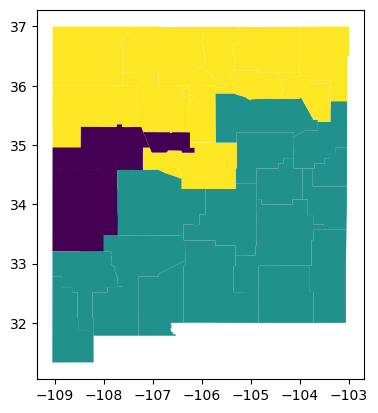

In [15]:
import pandas as pd

# Which district is each county assigned to?
assignment = [ -1 for u in G.nodes ]
    
# for each district j
for j in range(len(districts)):
    
    # for each node i in this district
    for i in districts[j]:
        
        # What is its GEOID?
        geoID = G.nodes[i]["GEOID20"]
        
        # Need to find this GEOID in the dataframe
        for u in G.nodes:
            if geoID == df['GEOID20'][u]: 
                assignment[u] = j # Node u from the dataframe should be assigned to district j

# Now add the assignments to a column of the dataframe and map it
df['assignment'] = assignment
my_fig = df.plot(column='assignment').get_figure()